In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold,train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import optuna

In [2]:
train = pd.read_csv('preprocessed_train.csv', encoding='euc-kr')
test = pd.read_csv('preprocessed_test.csv', encoding='euc-kr')

In [3]:
label = train['label']

In [4]:
train = train.drop(['분석데이터', 'label'], axis=1)
test = test.drop(['분석대상'], axis=1)

In [5]:
train

,numstrings,avlength,printables,entropy,paths,urls,registry,MZ,a_0,a_1,...,dist_86,dist_87,dist_88,dist_89,dist_90,dist_91,dist_92,dist_93,dist_94,dist_95
0,144,12.298611,1771,5.356616,0,0,0,1,2399,572,...,10,4,10,9,4,0,1,0,0,0
1,804,9.580846,7703,6.063542,0,0,0,6,183376,8477,...,43,121,84,78,47,36,40,45,27,36
2,2205,12.736054,28083,6.107050,9,0,0,6,1178,28,...,326,268,239,286,199,148,154,37,48,36
3,2602,10.288240,26770,5.373013,8,0,0,1,56851,2625,...,336,230,206,245,76,0,26,702,1,5
4,8980,23.252339,208806,5.775223,0,28,16,3,124274,5778,...,731,882,1171,1010,322,64,327,84,75,244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2018,13.938057,28127,5.940442,0,70,0,11,255044,17531,...,246,186,206,235,88,33,81,58,61,72
9996,1105,16.437104,18163,5.766962,0,11,0,3,181296,5127,...,199,57,134,123,20,25,28,25,41,13
9997,4,58.500000,234,3.811827,0,0,0,1,68736,2344,...,0,0,0,0,0,0,0,0,0,0
9998,3312,24.939312,82599,5.834730,0,39,0,8,90648,1338,...,438,985,806,851,113,123,181,100,75,86


In [6]:
test

,numstrings,avlength,printables,entropy,paths,urls,registry,MZ,a_0,a_1,...,dist_86,dist_87,dist_88,dist_89,dist_90,dist_91,dist_92,dist_93,dist_94,dist_95
0,5063,9.419514,47691,5.630504,6,1,1,11,68704,24061,...,212,4485,451,312,128,159,135,283,101,277
1,5347,15.560875,83204,5.773314,0,2,14,4,4026,1829,...,824,492,1159,574,90,25,47,22,26,27
2,4523,11.875083,53711,6.146246,0,37,0,1,65732,973,...,249,307,372,289,115,90,248,95,118,77
3,6174,7.378037,45552,6.473256,0,1,17,13,30028,1158,...,366,441,363,469,331,272,457,311,320,291
4,22,7.090909,156,5.324630,0,0,0,1,22922,464,...,0,1,3,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,473,5.835095,2760,6.547591,0,0,0,3,2367,199,...,28,27,33,45,25,27,26,23,26,30
4996,658,9.749240,6415,6.147939,0,9,0,3,30788,5078,...,170,101,83,48,27,22,27,17,19,40
4997,1111,9.737174,10818,5.775273,0,0,0,4,110979,7409,...,65,80,91,96,57,22,22,77,32,36
4998,1664,6.364183,10590,6.495400,0,1,0,6,114572,6942,...,95,103,116,95,62,59,94,54,74,72


In [7]:
print(f'train set have {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'test set have {test.shape[0]} rows and {test.shape[1]} columns.') 
print(f'label shape is {label.shape}') 

train set have 10000 rows and 616 columns.
test set have 5000 rows and 616 columns.
label shape is (10000,)


In [8]:
train.columns

Index(['numstrings', 'avlength', 'printables', 'entropy', 'paths', 'urls',
       'registry', 'MZ', 'a_0', 'a_1',
       ...
       'dist_86', 'dist_87', 'dist_88', 'dist_89', 'dist_90', 'dist_91',
       'dist_92', 'dist_93', 'dist_94', 'dist_95'],
      dtype='object', length=616)

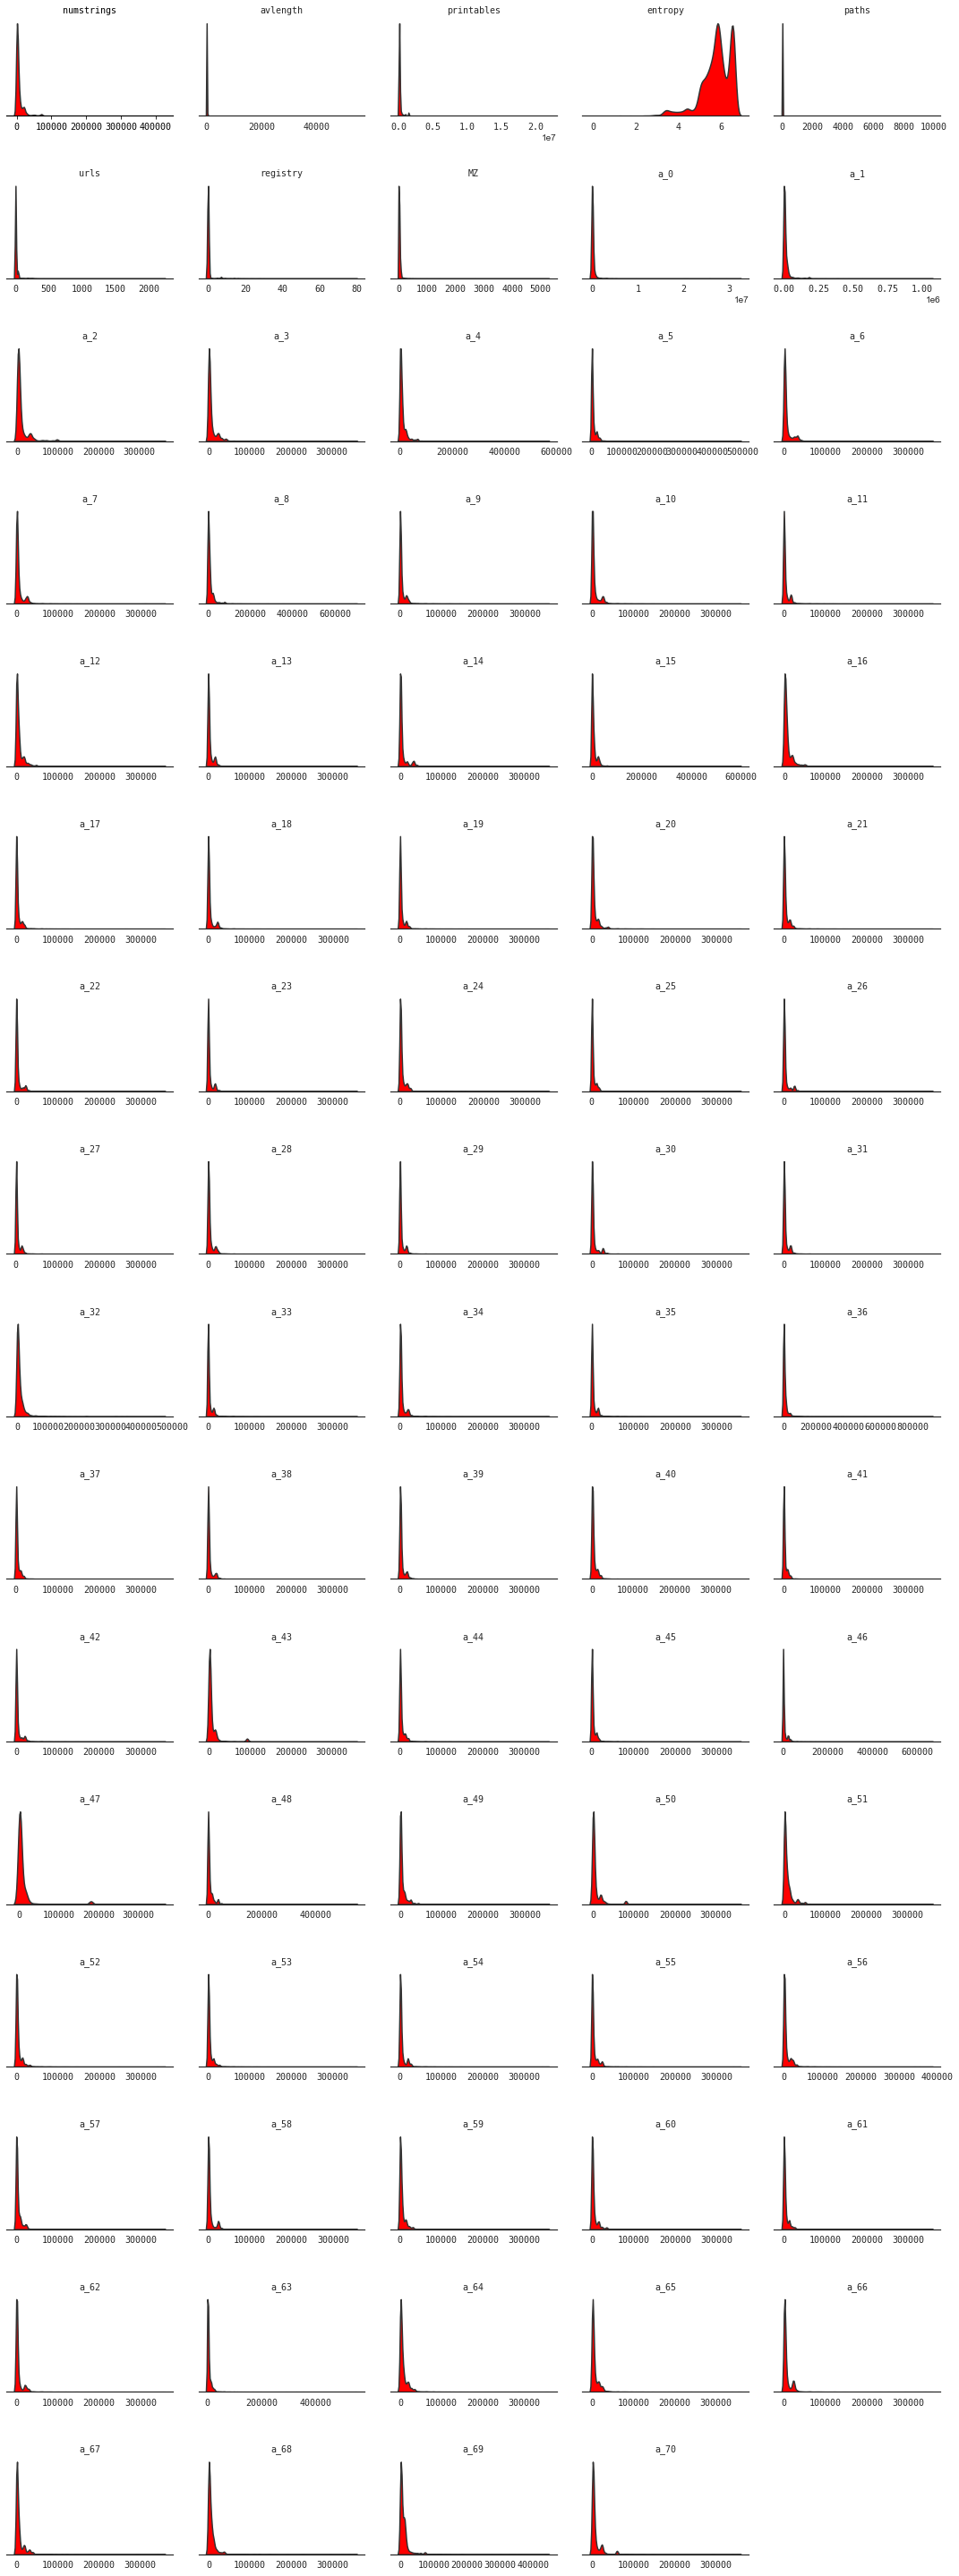

In [9]:
num_features = train.columns

fig = plt.figure(figsize = (15, 60))
for i in range(len(num_features[0:79])):
    plt.subplot(24,5,i+1)
    sns.set_style("white")
    plt.title(num_features[0:79][i], size = 10, fontname = 'monospace')
    a = sns.kdeplot(train[num_features[0:79][i]], shade = True, alpha = 0.9, linewidth = 1.5, facecolor='red', edgecolor=".2")
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname = 'monospace')
    plt.yticks([])
    for j in ['right', 'left', 'top']:
        a.spines[j].set_visible(False)
        a.spines['bottom'].set_linewidth(1.2)
        
fig.tight_layout(h_pad = 3)
plt.show()

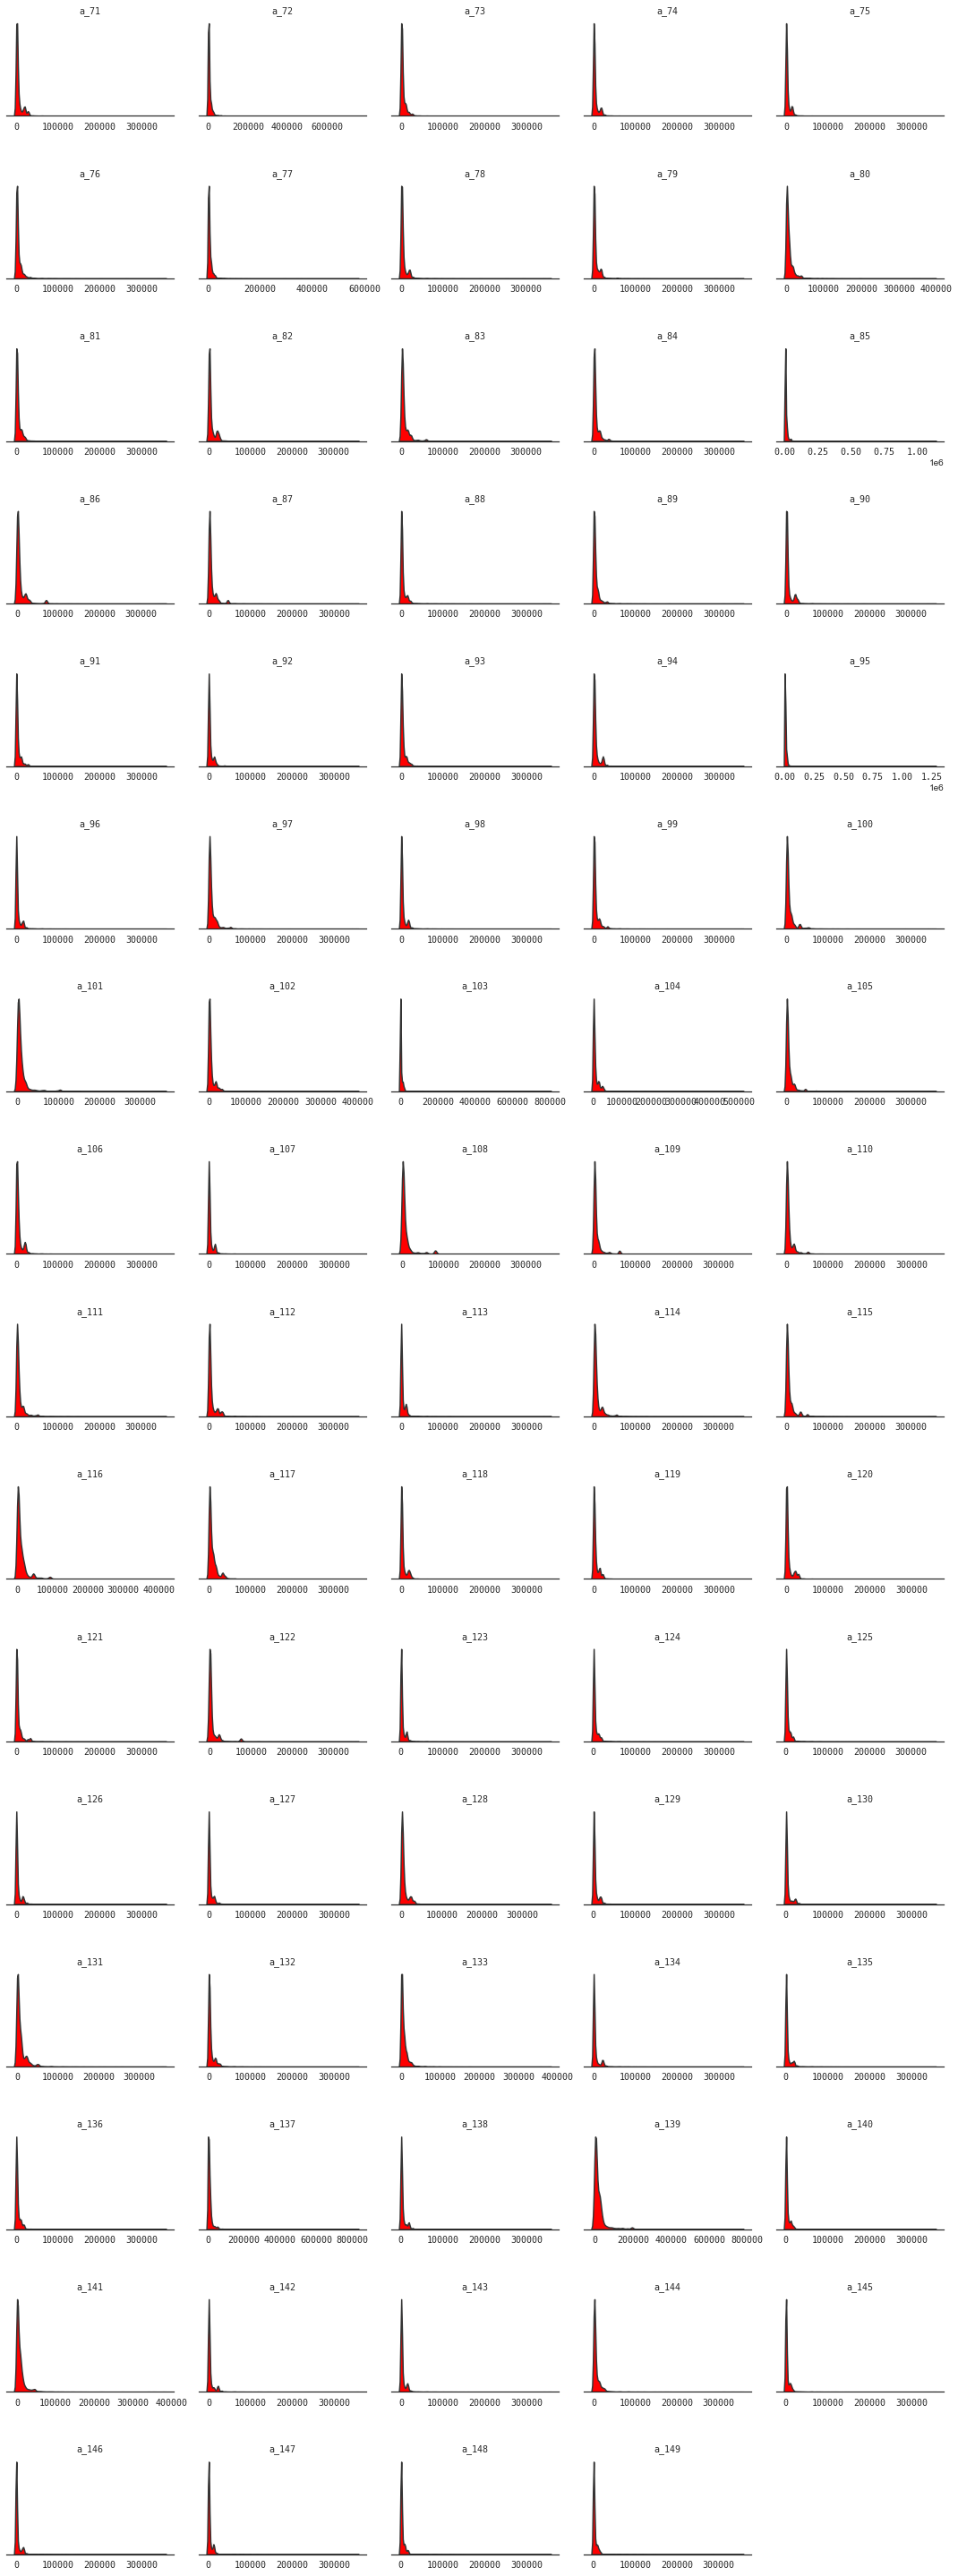

In [10]:
fig = plt.figure(figsize = (15, 60))
for i in range(len(num_features[79:158])):
    plt.subplot(24,5,i+1)
    sns.set_style("white")
    plt.title(num_features[79:158][i], size = 10, fontname = 'monospace')
    a = sns.kdeplot(train[num_features[79:158][i]], shade = True, alpha = 0.9, linewidth = 1.5, facecolor='red', edgecolor=".2")
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname = 'monospace')
    plt.yticks([])
    for j in ['right', 'left', 'top']:
        a.spines[j].set_visible(False)
        a.spines['bottom'].set_linewidth(1.2)
        
fig.tight_layout(h_pad = 3)
plt.show()

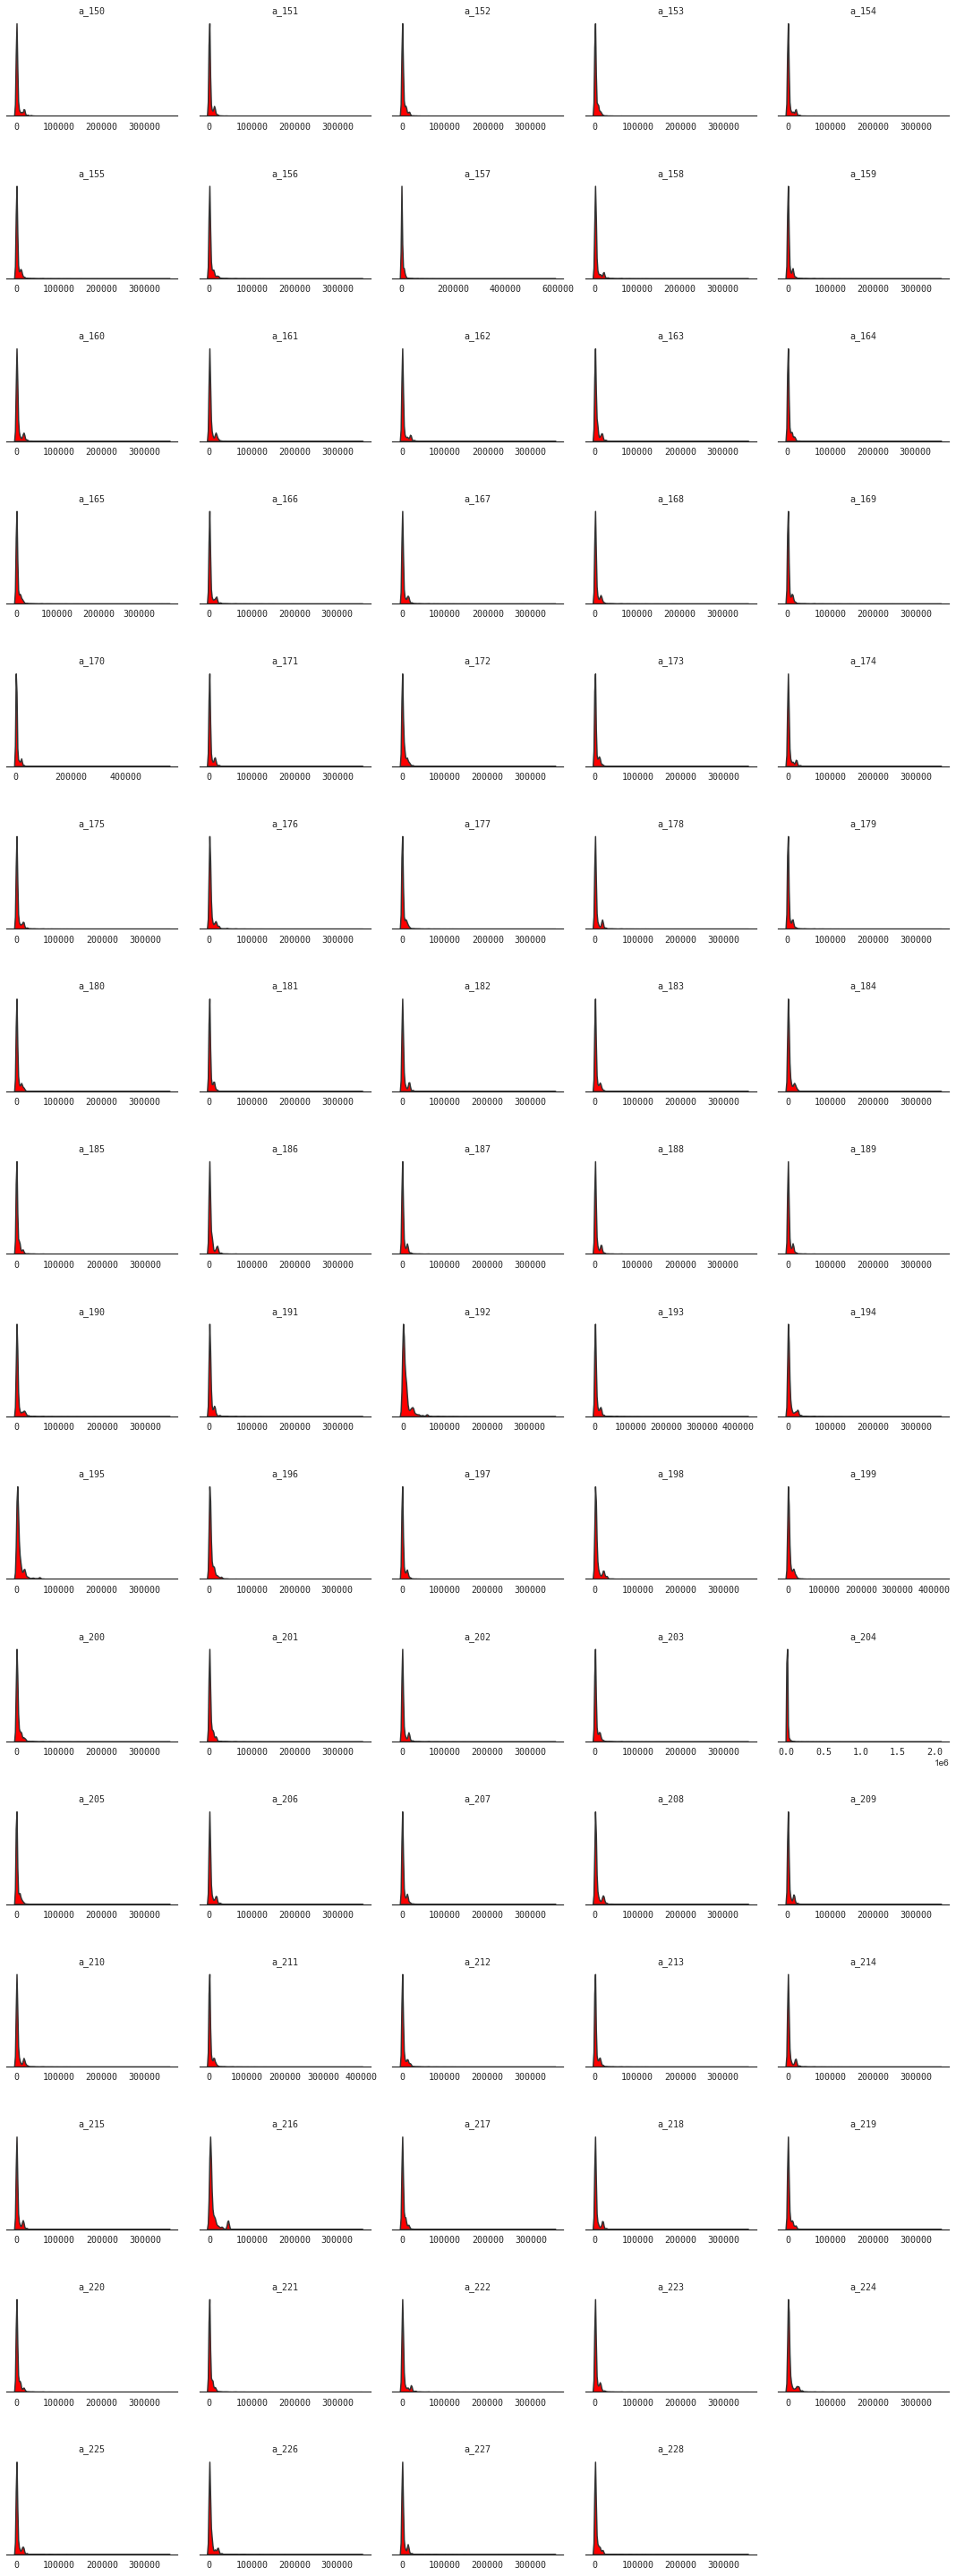

In [11]:
fig = plt.figure(figsize = (15, 60))
for i in range(len(num_features[158:237])):
    plt.subplot(24,5,i+1)
    sns.set_style("white")
    plt.title(num_features[158:237][i], size = 10, fontname = 'monospace')
    a = sns.kdeplot(train[num_features[158:237][i]], shade = True, alpha = 0.9, linewidth = 1.5, facecolor='red', edgecolor=".2")
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname = 'monospace')
    plt.yticks([])
    for j in ['right', 'left', 'top']:
        a.spines[j].set_visible(False)
        a.spines['bottom'].set_linewidth(1.2)
        
fig.tight_layout(h_pad = 3)
plt.show()

# Building Model - CatBoost

In [12]:
y = label

# optuna

In [13]:
def fit_cat(trial, x_train, y_train, x_test, y_test):
    params = {'iterations':trial.suggest_int("iterations", 1000, 100000),
              'od_wait':trial.suggest_int('od_wait', 500, 5000),
              'task_type':"GPU",
              'learning_rate' : trial.suggest_uniform('learning_rate', 0.02 , 0.06),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.30 , 0.33),
              'subsample': trial.suggest_uniform('subsample',0.8,1.0),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,15),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'bootstrap_type':'Poisson'
               }
    
    
    model = CatBoostClassifier(**params)
    model.fit(x_train, y_train,eval_set=[(x_test,y_test)], early_stopping_rounds=150, verbose=False)
    
    y_train_pred = model.predict_proba(x_train)[:,1]
    
    y_test_pred = model.predict_proba(x_test)[:,1]
    y_train_pred = np.clip(y_train_pred, 0.1, None)
    y_test_pred = np.clip(y_test_pred, 0.1, None)
    
    log = {
        "train roc_auc": roc_auc_score(y_train, y_train_pred),
        "valid roc_auc": roc_auc_score(y_test, y_test_pred)
    }
    
    return model, log

# catboost

In [14]:
# catboost params
cat_params = {'iterations': 2866,
 'od_wait': 3385,
 'learning_rate': 0.04280810491488757,
 'reg_lambda': 0.32139709692279206,
 'subsample': 0.8442605943226449,
 'random_strength': 22.468752639603235,
 'depth': 4,
 'min_data_in_leaf': 31,
 'leaf_estimation_iterations': 15,
 'task_type':"GPU",
 'bootstrap_type':'Poisson'}

In [15]:
folds = KFold(n_splits = 5, random_state = 2021, shuffle = True)

predictions = np.zeros(len(test))

for fold, (trn_idx, val_idx) in enumerate(folds.split(train)):
    print(f"Fold: {fold}")
    X_train, X_test = train.iloc[trn_idx], train.iloc[val_idx]
    y_train, y_test = y.iloc[trn_idx], y.iloc[val_idx]

    model = CatBoostClassifier(**cat_params)
   
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
                early_stopping_rounds=400,
                verbose=False)
    pred = model.predict_proba(X_test)[:,1]
    roc = roc_auc_score(y_test, pred)
    print(f" roc_auc_score: {roc}")
    print("-"*50)
    
    predictions += model.predict_proba(test)[:,1] / folds.n_splits 

Fold: 0


CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/cuda/cuda_lib/cuda_base.h:281: CUDA error 35: CUDA driver version is insufficient for CUDA runtime version